In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfilt, filtfilt, iirnotch, resample

#--------------------------------------------------------
# Utility Classes
#--------------------------------------------------------

class Scale:
    mini_volt = 1000
    micro_volt = 1000000

#--------------------------------------------------------
# Filtering Functions
#--------------------------------------------------------

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='bandpass', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    data_t = data.T
    filtered_t = np.zeros_like(data_t)
    for i in range(data_t.shape[0]):
        filtered_t[i, :] = sosfilt(sos, data_t[i, :])
    return filtered_t.T

def mains_removal(data, fs, notch_freq, quality_factor):
    b, a = iirnotch(notch_freq, quality_factor, fs)
    data_t = data.T
    filtered_t = filtfilt(b, a, data_t, axis=1, method='gust')
    return filtered_t.T

#--------------------------------------------------------
# Windowing Function
#--------------------------------------------------------

def window_with_overlap(data, sampling_frequency, window_time, overlap, no_channel):
    samples_per_window = int(sampling_frequency * (window_time / 1000))
    step_size = int(samples_per_window * (1 - overlap / 100))
    num_windows = (data.shape[1] - samples_per_window) // step_size + 1

    windows = np.zeros((num_windows, no_channel, samples_per_window))
    for i in range(num_windows):
        start = i * step_size
        end = start + samples_per_window
        windows[i] = data[:, start:end]
    return windows

#--------------------------------------------------------
# Data Loading Functions
#--------------------------------------------------------

def get_files_per_gesture(base_path, subject, no_gesture):
    path = os.path.join(base_path, f"subject_{subject}")
    if not os.path.exists(path):
        raise FileNotFoundError(f"Directory does not exist: {path}")
    data_file = os.listdir(path)

    gesture = {}
    for i in range(no_gesture):
        j = i + 1
        gesture[str(i)] = [f for f in data_file if f'G{j}' in f]
    return path, gesture

def get_data_per_gesture(base_path, subject, no_gesture, transpose=False):
    path, filenames = get_files_per_gesture(base_path, subject, no_gesture)
    gesture = {}

    for i in filenames:
        for idx, filename in enumerate(filenames[i]):
            data = pd.read_csv(os.path.join(path, filename)).values
            if transpose:
                data = data.T
            if idx == 0:
                stack_data = data
            else:
                stack_data = np.column_stack((stack_data, data))  # Align data column-wise
        gesture[str(i)] = stack_data
    return gesture

#--------------------------------------------------------
# Preprocessing Functions
#--------------------------------------------------------

def preprocess_data(data, fs, notch_freq, quality_factor, lowcut, highcut, order, target_fs=None):
    notched_data = mains_removal(data, fs=fs, notch_freq=notch_freq, quality_factor=quality_factor)
    filtered_data = butter_bandpass_filter(notched_data, lowcut=lowcut, highcut=highcut, fs=fs, order=order)

    # Downsample if target_fs is provided
    if target_fs and fs != target_fs:
        num_samples = int(data.shape[1] * target_fs / fs)
        downsampled_data = resample(filtered_data, num=num_samples, axis=1)
        return downsampled_data
    return filtered_data

def truncate_to_min_length(data1, data2):
    """
    Truncate two datasets to the same minimum length along the time axis.
    """
    min_length = min(data1.shape[1], data2.shape[1])
    return data1[:, :min_length], data2[:, :min_length]

#--------------------------------------------------------
# Main Function to Get Data
#--------------------------------------------------------

def get_data_subject_specific(subject, no_gesture, emg_fs, eeg_fs, 
                              notch_freq, quality_factor, emg_fc, emg_fh, 
                              eeg_fc, eeg_fh, order, target_fs, window_time, overlap,
                              emg_base_path, eeg_base_path):
    emg_gestures = get_data_per_gesture(emg_base_path, subject, no_gesture, transpose=False)
    eeg_gestures = get_data_per_gesture(eeg_base_path, subject, no_gesture, transpose=True)

    data_stack_emg = []
    data_stack_eeg = []
    labels = []

    for idx in emg_gestures:
        emg_data = preprocess_data(emg_gestures[idx], emg_fs, notch_freq, quality_factor, emg_fc, emg_fh, order, target_fs)
        eeg_data = preprocess_data(eeg_gestures[idx], eeg_fs, notch_freq, quality_factor, eeg_fc, eeg_fh, order, target_fs)

        # Truncate both signals to the same length
        emg_data, eeg_data = truncate_to_min_length(emg_data, eeg_data)

        # Apply windowing
        emg_windows = window_with_overlap(emg_data, target_fs, window_time, overlap, emg_data.shape[0])
        eeg_windows = window_with_overlap(eeg_data, target_fs, window_time, overlap, eeg_data.shape[0])

        # Ensure number of windows matches for labels
        num_windows = min(emg_windows.shape[0], eeg_windows.shape[0])
        emg_windows = emg_windows[:num_windows]
        eeg_windows = eeg_windows[:num_windows]

        labels.extend([int(idx)] * num_windows)

        data_stack_emg.append(emg_windows)
        data_stack_eeg.append(eeg_windows)

    X_emg = np.vstack(data_stack_emg)
    X_eeg = np.vstack(data_stack_eeg)
    y = np.array(labels)

    return X_emg, X_eeg, y

#--------------------------------------------------------
# Example Usage
#--------------------------------------------------------

subject = 1
no_gesture = 7
emg_fs = 200
eeg_fs = 250
notch_freq = 60
quality_factor = 30
emg_fc, emg_fh = 5, 50
eeg_fc, eeg_fh = 5, 50
order = 4
window_time = 1000
overlap = 80
target_fs = 200

emg_path = "/home/tipu/Downloads/EEG-EMG-Data/EMG, EEG upper limb gesture data/EEG_DATA/data/csv_data"
eeg_path = "/home/tipu/Downloads/EEG-EMG-Data/EMG, EEG upper limb gesture data/EMG_DATA/data/csv_data"

X_emg, X_eeg, y = get_data_subject_specific(
    subject=subject,
    no_gesture=no_gesture,
    emg_fs=emg_fs,
    eeg_fs=eeg_fs,
    notch_freq=notch_freq,
    quality_factor=quality_factor,
    emg_fc=emg_fc,
    emg_fh=emg_fh,
    eeg_fc=eeg_fc,
    eeg_fh=eeg_fh,
    order=order,
    target_fs=target_fs,
    window_time=window_time,
    overlap=overlap,
    emg_base_path=emg_path,
    eeg_base_path=eeg_path
)

# Save processed data
pd.DataFrame(X_emg.reshape(X_emg.shape[0], -1)).to_csv("processed_emg1.csv", index=False)
pd.DataFrame(X_eeg.reshape(X_eeg.shape[0], -1)).to_csv("processed_eeg1.csv", index=False)
pd.DataFrame(y, columns=["Label"]).to_csv("labels1.csv", index=False)

print("Data has been processed and saved to CSV files.")

In [47]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the datasets
eeg_data = pd.read_csv('processed_eeg1.csv')
emg_data = pd.read_csv('processed_emg1.csv')
labels = pd.read_csv('labels1.csv')

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize EEG data
normalized_eeg_data = scaler.fit_transform(eeg_data)

# Normalize EMG data
normalized_emg_data = scaler.fit_transform(emg_data)

# Convert normalized data back to DataFrame
normalized_eeg_df = pd.DataFrame(normalized_eeg_data, columns=eeg_data.columns)
normalized_emg_df = pd.DataFrame(normalized_emg_data, columns=emg_data.columns)


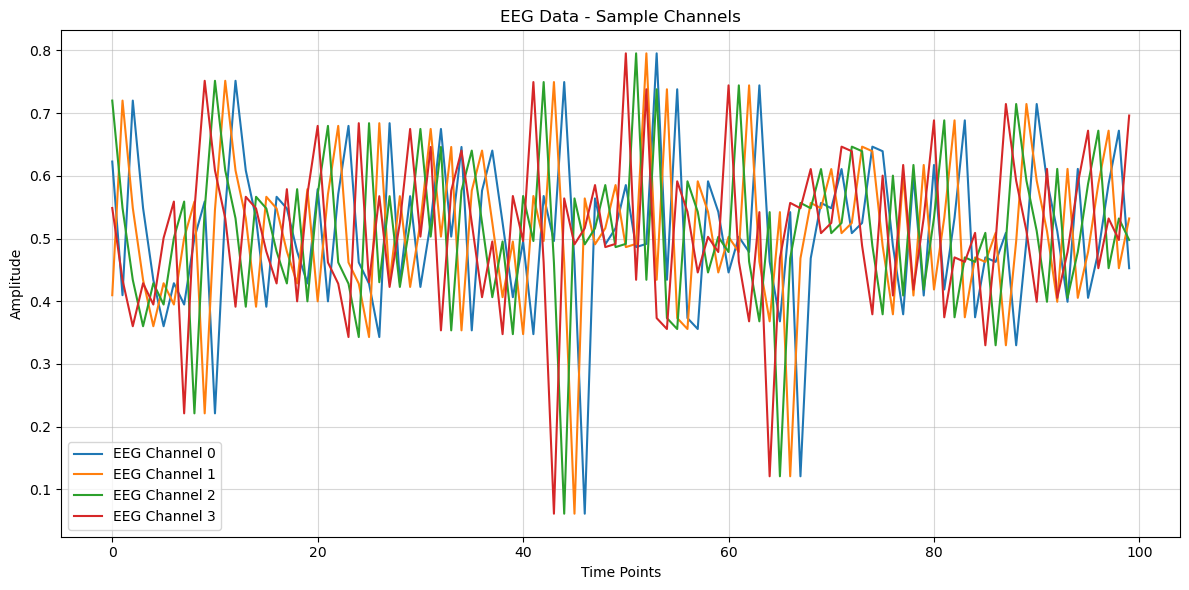

In [48]:
# Plot EEG Data
plt.figure(figsize=(12, 6))

# Plot the first few EEG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(normalized_eeg_df.iloc[0, channel:channel+100].values, label=f'EEG Channel {channel}')

plt.title('EEG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


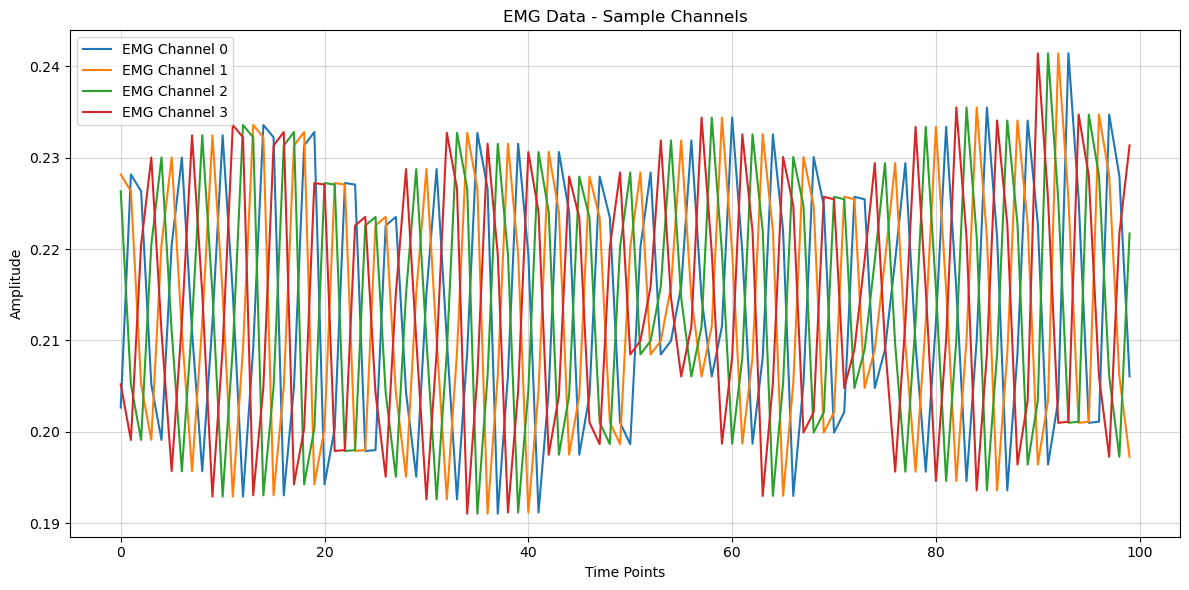

In [49]:

# Plot EMG Data
plt.figure(figsize=(12, 6))

# Plot the first few EMG channels
for channel in range(4):  # Adjust the range for more/less channels
    plt.plot(normalized_emg_df.iloc[0, channel:channel+100].values, label=f'EMG Channel {channel}')

plt.title('EMG Data - Sample Channels')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


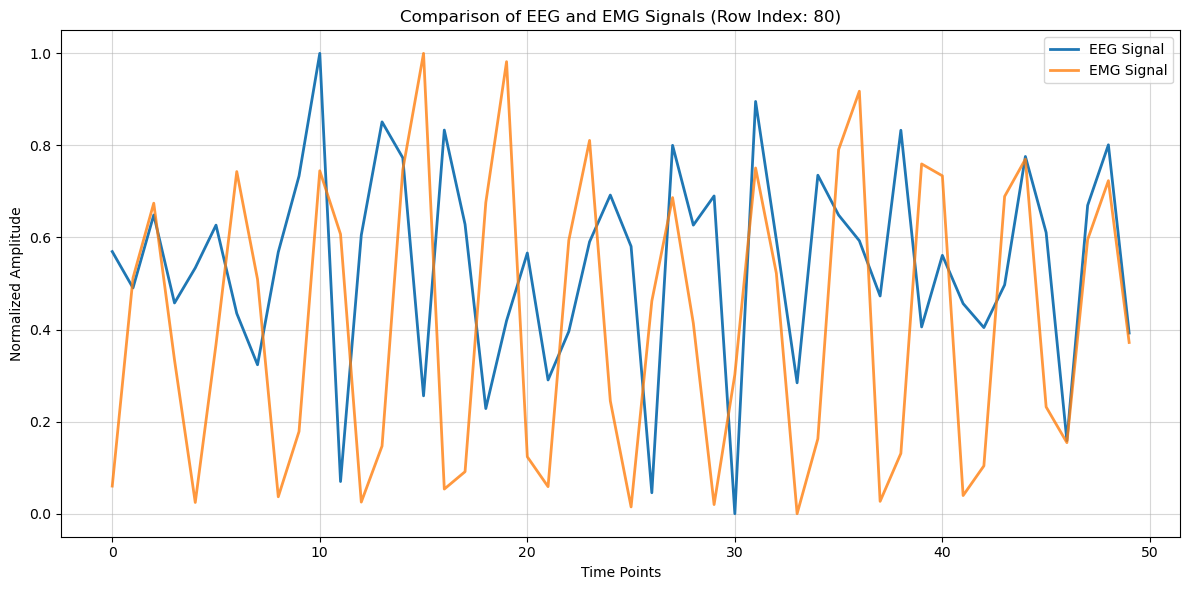

In [50]:
# Select a specific row to plot
row_index = 80  # Change this to select a different row
eeg_signal =normalized_eeg_df.iloc[row_index, :50].values  # First 100 data points
emg_signal = normalized_emg_df.iloc[row_index, :50].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [51]:
eeg_duplicates = normalized_eeg_df.duplicated().sum()
emg_duplicates = normalized_emg_df.duplicated().sum()
label_duplicates = labels.duplicated().sum()


In [52]:
print(f"Number of duplicate rows in EEG data: {eeg_duplicates}")
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")
print(f"Number of duplicate rows in Labels: {label_duplicates}")


Number of duplicate rows in EEG data: 0
Number of duplicate rows in EMG data: 0
Number of duplicate rows in Labels: 1327


In [53]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the datasets
eeg_data = pd.read_csv('processed_eeg1.csv')
emg_data = pd.read_csv('processed_emg1.csv')
labels = pd.read_csv('labels1.csv')

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize EEG data
normalized_eeg_data = scaler.fit_transform(eeg_data)

# Normalize EMG data
normalized_emg_data = scaler.fit_transform(emg_data)

# Convert normalized data back to DataFrame
normalized_eeg_df = pd.DataFrame(normalized_eeg_data, columns=eeg_data.columns)
normalized_emg_df = pd.DataFrame(normalized_emg_data, columns=emg_data.columns)

# Save normalized datasets
normalized_eeg_df.to_csv('normalized_eeg_data.csv', index=False)
normalized_emg_df.to_csv('normalized_emg_data.csv', index=False)
labels.to_csv('labels.csv', index=False)  # Labels remain unchanged

print("EEG and EMG data have been normalized and saved to CSV files.")


EEG and EMG data have been normalized and saved to CSV files.


In [54]:
# Load the datasets
eeg_data = pd.read_csv('normalized_eeg_data.csv')
emg_data = pd.read_csv('normalized_emg_data.csv')
labels = pd.read_csv('labels.csv')

In [55]:
# Print the sizes of the datasets
print(f"EEG Data Size: {eeg_data.shape}")
print(f"EMG Data Size: {emg_data.shape}")
print(f"Labels Size: {labels.shape}")


EEG Data Size: (1334, 1600)
EMG Data Size: (1421, 1600)
Labels Size: (1334, 1)


In [56]:
# Load the datasets
eeg_data = pd.read_csv('normalized_eeg_data.csv')
emg_data = pd.read_csv('normalized_emg_data.csv')
labels = pd.read_csv('labels.csv')

# Data augmentation functions
def add_noise(data, noise_level=0.01):
    """Add random noise to the data."""
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

def scale_data(data, scale_factor=1.1):
    """Scale the data."""
    return data * scale_factor

def time_shift(data, shift):
    """Shift the data along the time axis."""
    return np.roll(data, shift, axis=0)

def flip_data(data):
    """Flip the data vertically."""
    return -data

# Apply augmentations
augmented_eeg = []
augmented_emg = []
augmented_labels = []

for i in range(len(eeg_data)):
    eeg_row = eeg_data.iloc[i].values
    emg_row = emg_data.iloc[i].values
    label = labels.iloc[i].values[0]

    # Original data
    augmented_eeg.append(eeg_row)
    augmented_emg.append(emg_row)
    augmented_labels.append(label)

    # Augmentation 1: Add noise
    augmented_eeg.append(add_noise(eeg_row))
    augmented_emg.append(add_noise(emg_row))
    augmented_labels.append(label)

    # Augmentation 2: Scale data
    augmented_eeg.append(scale_data(eeg_row))
    augmented_emg.append(scale_data(emg_row))
    augmented_labels.append(label)

    # Augmentation 3: Time shift
    augmented_eeg.append(time_shift(eeg_row, shift=5))
    augmented_emg.append(time_shift(emg_row, shift=5))
    augmented_labels.append(label)

    # Augmentation 4: Flip data
    augmented_eeg.append(flip_data(eeg_row))
    augmented_emg.append(flip_data(emg_row))
    augmented_labels.append(label)

# Convert augmented data to DataFrame
augmented_eeg_df = pd.DataFrame(augmented_eeg, columns=eeg_data.columns)
augmented_emg_df = pd.DataFrame(augmented_emg, columns=emg_data.columns)
augmented_labels_df = pd.DataFrame(augmented_labels, columns=['Label'])

# Save augmented data
augmented_eeg_df.to_csv('augmented_eeg_data5.csv', index=False)
augmented_emg_df.to_csv('augmented_emg_data5.csv', index=False)
augmented_labels_df.to_csv('augmented_labels5.csv', index=False)

print("Data augmentation completed. Augmented files saved.")


Data augmentation completed. Augmented files saved.


In [57]:
emg_duplicates = emg_data.duplicated().sum()
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")

Number of duplicate rows in EMG data: 0


In [58]:
import numpy as np
import pandas as pd
# Load the datasets
eeg_data = pd.read_csv('augmented_eeg_data5.csv')
emg_data = pd.read_csv('augmented_emg_data5.csv')
labels = pd.read_csv('augmented_labels5.csv')

In [59]:
# Print the sizes of the datasets
print(f"EEG Data Size: {eeg_data.shape}")
print(f"EMG Data Size: {emg_data.shape}")
print(f"Labels Size: {labels.shape}")


EEG Data Size: (6670, 1600)
EMG Data Size: (6670, 1600)
Labels Size: (6670, 1)


In [26]:
eeg_duplicates = eeg_data.duplicated().sum()
emg_duplicates = emg_data.duplicated().sum()
label_duplicates = labels.duplicated().sum()

In [27]:
print(f"Number of duplicate rows in EEG data: {eeg_duplicates}")
print(f"Number of duplicate rows in EMG data: {emg_duplicates}")
print(f"Number of duplicate rows in Labels: {label_duplicates}")


Number of duplicate rows in EEG data: 0
Number of duplicate rows in EMG data: 0
Number of duplicate rows in Labels: 6663


Label Distribution:
Label
0    955
1    955
3    955
6    955
2    950
4    950
5    950
Name: count, dtype: int64


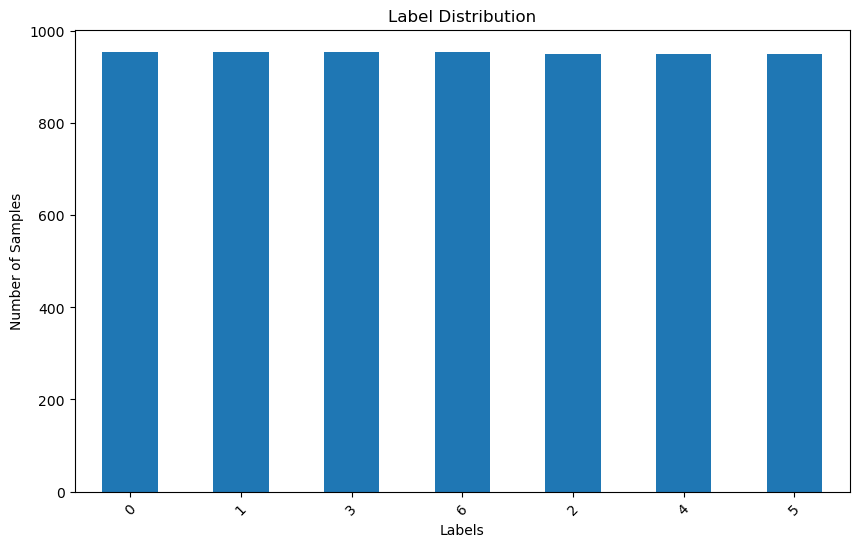


Maximum label count: 955
Minimum label count: 950
Difference between max and min counts: 5

The dataset is fairly balanced.


In [28]:
import matplotlib.pyplot as plt
# Check the distribution of labels
label_distribution = labels['Label'].value_counts()

# Display the distribution
print("Label Distribution:")
print(label_distribution)

# Plot the label distribution
plt.figure(figsize=(10, 6))
label_distribution.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Check for balance
max_count = label_distribution.max()
min_count = label_distribution.min()
print("\nMaximum label count:", max_count)
print("Minimum label count:", min_count)
print("Difference between max and min counts:", max_count - min_count)

if max_count - min_count <= 0.1 * max_count:
    print("\nThe dataset is fairly balanced.")
else:
    print("\nThe dataset is imbalanced. Consider applying techniques to balance it.")

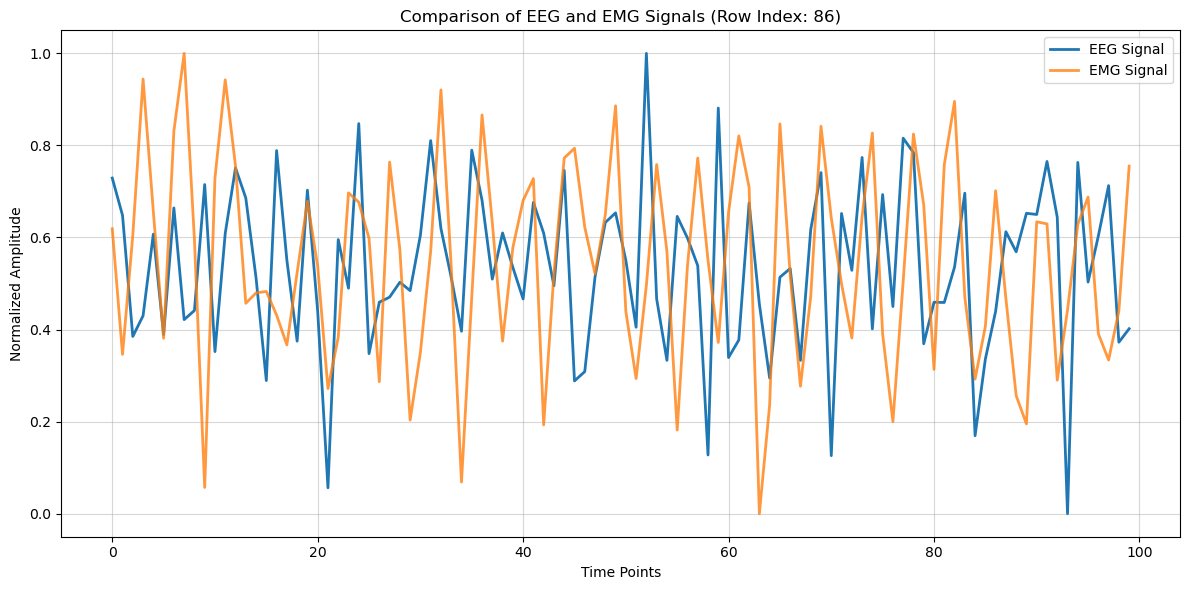

In [29]:
# Select a specific row to plot
row_index = 86  # Change this to select a different row
eeg_signal = eeg_data.iloc[row_index, :100].values  # First 100 data points
emg_signal = emg_data.iloc[row_index, :100].values  # First 100 data points

# Normalize EMG data to match EEG scale for better comparison (optional)
emg_signal = (emg_signal - emg_signal.min()) / (emg_signal.max() - emg_signal.min())
eeg_signal = (eeg_signal - eeg_signal.min()) / (eeg_signal.max() - eeg_signal.min())

# Plot the signals together
plt.figure(figsize=(12, 6))

plt.plot(eeg_signal, label='EEG Signal', linewidth=2)
plt.plot(emg_signal, label='EMG Signal', linewidth=2, alpha=0.8)

# Add titles and labels
plt.title('Comparison of EEG and EMG Signals (Row Index: {})'.format(row_index))
plt.xlabel('Time Points')
plt.ylabel('Normalized Amplitude')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [30]:
# Print the sizes of the datasets
print(f"EEG Data Size: {eeg_data.shape}")
print(f"EMG Data Size: {emg_data.shape}")
print(f"Labels Size: {labels.shape}")


EEG Data Size: (6670, 1600)
EMG Data Size: (6670, 1600)
Labels Size: (6670, 1)
